# Task 1

Part a) Describe Domain adversarial training (dat) in your own words:

- The goal of DAT is to train the Domain predictor and the label predictor at the same time
- To achieve this goal we need to achieve two objectives
    - minimize the error of the label predictor 
    - maximize the error of the domain predictor
- These goals don't mix well together... 
    - therefore dann introduces an ANN architecture to solve this issue.
    - the ANN is split in three "models", the feature extractor,     
```mermaid
graph TD;
    FeatureExtractor -> LabelPredictor;
    FeatureExtractor -> DomainPredictor;
```
gradient reversal layer to achieve this



adept python for density estimation

In [20]:
import torch
import mnist_m
import gradientreversal

# constants
NUM_WORKERS = 8
BATCH_SIZE = 100
EPOCHS = 10


In [21]:
# create custom tensor
t = torch.ones((10, 1), requires_grad=True)
# apply the gradient reversal function
gr = gradientreversal.grad_reverse(t)
# scale to scalar
l = gr.sum()
# perform backwards pass and print grad
l.backward()
print(t.grad)

tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]])


What is the relevance of the parameter $\alpha$ ?
- scale the gradient
- reverse it to get from min problem to max problem

In [22]:
# Prepare mnist-m and show some samples
import torchvision

mnist_m_train = mnist_m.MNISTM(
    root="./data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

mnist_m_test = mnist_m.MNISTM(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

mnist_rgb_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),            
            torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            ])   
            
mnist_train = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=mnist_rgb_transform
)

mnist_test = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=mnist_rgb_transform
)

mnist_m_train_dataloader = torch.utils.data.DataLoader(mnist_m_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
mnist_m_test_dataloader = torch.utils.data.DataLoader(mnist_m_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

./data/MNISTM/processed/mnist_m_train.pt
./data/MNISTM/processed/mnist_m_test.pt


In [23]:
import matplotlib.pyplot as plt

# python path magic, TODO make this a package and install via pip
import os, sys
currentdir = os.path.dirname(os.path.realpath("."))
sys.path.append(currentdir)

import util_functions as uf

%matplotlib inline

(28, 28, 3)


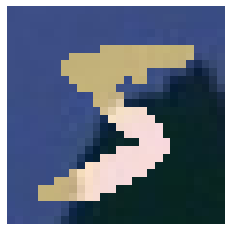

(28, 28, 3)


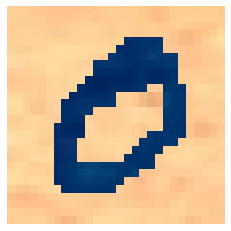

(28, 28, 3)


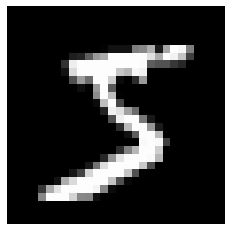

(28, 28, 3)


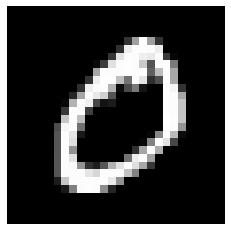

In [24]:
import numpy as np

def show_image_rgb(x):
    x = x.transpose((1, 2, 0))
    print(x.shape)
    x = np.clip(x, 0, 1)
    plt.imshow(x)
    plt.axis("off")
    plt.show()


def visualize_from_dataloader(dataloader: torch.utils.data.DataLoader, samples: int) -> None:
    if dataloader.batch_size < samples:
        print("error")

    image, label = next(iter(dataloader))
    for s in range(samples):
        show_image_rgb(image[s].detach().numpy())

visualize_from_dataloader(mnist_m_train_dataloader, 2)
visualize_from_dataloader(mnist_train_dataloader, 2)

In [25]:
# DANN and ANN
import pytorch_lightning as pl
from torch import nn

class DANN(nn.Module):

    def __init__(self):
        super(DANN, self).__init__()        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1),                              
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),    
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),     
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),                
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(in_features=(32 * 4 * 4), out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=10),
            nn.Softmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(in_features=(32 * 4 * 4), out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=2),
            nn.Softmax(dim=1),
        )

    def forward(self, x, alpha):
        feature_out = self.feature_extractor(x)
        feature_out = feature_out.view(feature_out.size(0), -1)       
        class_out = self.class_classifier(feature_out)
        domain_in = gradientreversal.grad_reverse(feature_out, alpha)
        domain_out = self.domain_classifier(domain_in)
        return class_out, domain_out


class ANN(nn.Module):

    def __init__(self):
        super(ANN, self).__init__()        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1),                              
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),    
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),     
            nn.ReLU(),                      
            nn.AvgPool2d(kernel_size=(2, 2), stride=2),                
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(in_features=(32 * 4 * 4), out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        feature_out = self.feature_extractor(x)
        feature_out = feature_out.view(feature_out.size(0), -1)       
        class_out = self.class_classifier(feature_out)
        return class_out


def train_ann(net:ANN, epochs, optimizer, dataloader):
    for epoch in range(epochs):

        for image, label in dataloader:

            net.zero_grad()
            out = net(image)
            loss = nn.functional.nll_loss(out, label)

            loss.backward()
            optimizer.step()
        
        print(f"finished epoch: {epoch}")


def train_dann(net:DANN, epochs, optimizer, dataloader_0, dataloader_1):
    for epoch in range(epochs):
        # calc alpha
        alpha = 2. / (1+np.exp(-10. * epoch /(epochs-1))) - 1

        for batch_0, batch_1 in zip(dataloader_0, dataloader_1):
            image_0, label_0 = batch_0
            image_1, label_1 = batch_1

            net.zero_grad()
            # define labels for the domain classifier
            domain_label_0 = torch.zeros_like(label_0)
            domain_label_1 = torch.ones_like(label_1)

            class_out_0, domain_out_0 = net(image_0, alpha)
            error_class_0 = nn.functional.nll_loss(class_out_0, label_0)
            error_domain_0 = nn.functional.nll_loss(domain_out_0, domain_label_0)


            _, domain_out_1 = net(image_1, alpha)
            error_domain_1 = nn.functional.nll_loss(domain_out_1, domain_label_1)
            
            loss = error_class_0 + error_domain_0 + error_domain_1
            loss.backward()
            optimizer.step()
        
        print(f"finished epoch: {epoch}")


def test_dann(net: DANN, dataloader:torch.utils.data.DataLoader) -> float:
    correct = 0
    for batch, (image, label) in enumerate(dataloader):
        # alpha parameter is irrelevant here, since we do no backwards pass
        class_out, domain_out = net(image, alpha=1.)
        _, clo = torch.max(class_out, dim=1)
        correct += torch.sum(clo == label)

    return correct / len(dataloader)


def test_network(net: ANN, dataloader:torch.utils.data.DataLoader) -> float:
    correct = 0
    for batch, (image, label) in enumerate(dataloader):
        # alpha parameter is irrelevant here, since we do no backwards pass
        class_out = net(image)
        _, clo = torch.max(class_out, dim=1)
        correct += torch.sum(clo == label)

    return correct / len(dataloader)

In [27]:

dann = DANN()
for parameter in dann.parameters():
    parameter.requires_grad = True
    
optimizer = torch.optim.Adam(dann.parameters(), lr=1e-3)

train_dann(dann, EPOCHS, optimizer, mnist_train_dataloader, mnist_m_train_dataloader)

finished epoch: 0
finished epoch: 1
finished epoch: 2
finished epoch: 3
finished epoch: 4
finished epoch: 5
finished epoch: 6
finished epoch: 7
finished epoch: 8
finished epoch: 9


In [28]:
test_acc_mn = test_dann(dann, mnist_test_dataloader)
test_acc_mnm = test_dann(dann, mnist_m_test_dataloader)

print(f"test_accuracy MNIST: {test_acc_mn} MNIST-M: {test_acc_mnm}")

test_accuracy MNIST: 98.70999908447266 MNIST-M: 60.86000061035156


In [29]:
ann = ANN()
for parameter in ann.parameters():
    parameter.requires_grad = True
    
optimizer = torch.optim.Adam(ann.parameters(), lr=1e-3)

train_ann(ann, EPOCHS, optimizer, mnist_train_dataloader)

finished epoch: 0
finished epoch: 1
finished epoch: 2
finished epoch: 3
finished epoch: 4
finished epoch: 5
finished epoch: 6
finished epoch: 7
finished epoch: 8
finished epoch: 9


In [30]:
test_acc_mn = test_network(ann, mnist_test_dataloader)
test_acc_mnm = test_network(ann, mnist_m_test_dataloader)
torch.distributions.multivariate_normal

print(f"test_accuracy MNIST: {test_acc_mn} MNIST-M: {test_acc_mnm}")

test_accuracy MNIST: 98.83999633789062 MNIST-M: 57.650001525878906
